# TO - DO
Author: [@Kevin Arvai](https://www.kaggle.com/kevinarvai)  
Source: [Outlier Detection Practice: uni/multivariate](https://www.kaggle.com/kevinarvai/outlier-detection-practice-uni-multivariate)  
Translator: [@SSANGMAN](https://github.com/SSANGMAN)


다음 블로그의 게시물을 통해서 이 주제에 관심을 가지게 되었다.[this blog post](https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/).
이 커널의 Version 8은 추출된 분포와 관련하여 Outlier Detection을 목표로 한다. 일반적인 **parametric** 방법은 표준 편차와 사분위 간 범위를 사용한다.  **Nonparametric** 방법은 더 복잡하지만 Clustering을 통해 적절한 성능을 보일 수 있다. 이 커널에서는 **parametric** 와  **nonaparametric** 방법을 **univariate** 과 **multivariate** 데이터를 이용해 탐색한다.


# Table of Contents
1. [Parametric methods: Univariate](#Parametric-methods:-Univariate)
    1. [Standard Deviation](#Standard-Deviation)
    2. [Compare Standard Deviation and IQR](#Compare-Standard-Deviation-and-IQR)  
2. [Nonparametric methods: Univariate](#Nonparametric-methods:-Univariate)  
    1. [Isolation Forest](#Isolation-Forest)  
3. [Parametric methods: Multivariate](#Parametric-methods:-Multivariate)  
    1. [EllipticEnvelope](#EllipticEnvelope)  
4. [Nonparametric methods: Multivariate](#Nonparametric-methods:-Multivariate)  
    1. [DBSCAN](#DBSCAN)  
    2. [LocalOutlierFactor](#LocalOutlierFactor)

In [28]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

import warnings
warnings.filterwarnings('ignore')

# Parametric methods: Univariate
먼저, parametric 방법을 탐색하기 위해 **normal distribution** 를 갖는 데이터프레임을 생성한다.

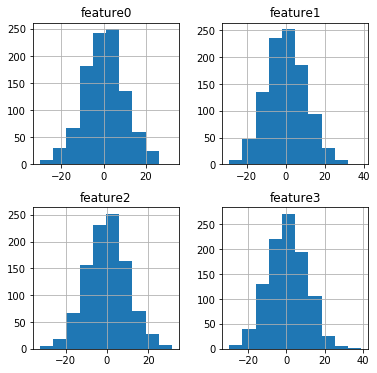

In [2]:
# seed for reproducibility
np.random.seed(42)
n_feats=4
dummydf = pd.DataFrame(np.random.normal(scale=10.0, size=(1000, n_feats)),
                           columns=['feature{}'.format(i) for i in range(n_feats)])
# all normally distributed
dummydf.hist(figsize=(6,6));

In [3]:
# enough variation between features to show outliers
dummydf.describe()

,feature0,feature1,feature2,feature3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.306239,0.248285,-0.082552,0.300861
std,9.639191,10.118843,10.060754,10.069640
min,-30.195122,-28.962554,-32.412673,-29.911360
25%,-6.129422,-6.770368,-6.752986,-6.708710
50%,0.561874,0.202097,-0.075088,0.211577
75%,6.648813,6.938808,6.422820,6.958780
max,32.430930,38.527315,31.520567,39.262377


표준 편차와 사분위간 범위를 이용하여 Pandas `Series`에서 Outlier를 통계적으로 식별하는 두 가지 함수를 정의한다.

In [10]:
def out_std(s, nstd=3.0, return_thresholds=False):
    """
    표준 편차를 사용하여 Series에 대한 열 기준 Outlier를 Boolean Mask를 반환한다.
    param nstd:
    평균에서 Outlier를 고려하는 표준 편차 값 설정
    :type nstd: ``float``
    param return_thresholds:
    True는 하한과 상한을 반환하며, 플로팅하기에 좋다
    False는 Masking된 배열을 반환한다.
    :type return_thresholds: ``bool``
    """
    data_mean, data_std = s.mean(), s.std()
    cut_off = data_std * nstd
    lower, upper = data_mean - cut_off, data_mean + cut_off
    if return_thresholds:
        return lower, upper
    else:
        return [True if x < lower or x > upper else False for x in s]

def out_iqr(s, k=1.5, return_thresholds=False):
    """
    사분위수를 사용하여 Series에 대한 열 기준 Outlier를 Boolean Mask를 반환한다.
    param k:
        IQR에 곱하기 위한 Cut Off 설정 # 일반적으로 통계학에서 1.5 IQR에서 벗어난 값을 Outlier로 결정
    :type k: ``float``
    param return_thresholds:
        True는 하한과 상한을 반환하며, 플로팅하기에 좋다
        False는 Masking된 배열을 반환한다.
    :type return_thresholds: ``bool``
    """
    # calculate interquartile range
    q25, q75 = np.percentile(s, 25), np.percentile(s, 75)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    if return_thresholds:
        return lower, upper
    else: # identify outliers
        return [True if x < lower or x > upper else False for x in s]

Standard Deviation:
![](https://qph.fs.quoracdn.net/main-qimg-a86744ea6f27735b381e097bed60e048.webp)  

Interquartile Range:
![](http://www.statisticshowto.com/wp-content/uploads/2012/03/iqr.jpg)

두 함수 모두 Boolean 값을 반환한다.

이제, 정규 분포에서 무작위로 생성된 데이터에 대해 함수를 적용시켜 본다.

### Standard Deviation

In [11]:
# outlier_mask is a boolean list identifies the indices of the outliers
outlier_mask = out_std(dummydf['feature0'], nstd=3.0)
# first 10 elements
outlier_mask[:10]

[False, False, False, False, False, False, False, False, False, False]

Outlier를 식별하고, 어떤 값인지 확인한다.

In [12]:
dummydf['feature0'][outlier_mask]

506   -30.195122
788   -29.069882
929    32.430930
Name: feature0, dtype: float64

피쳐의 분포에 따른 Outlier를 시각화한다.

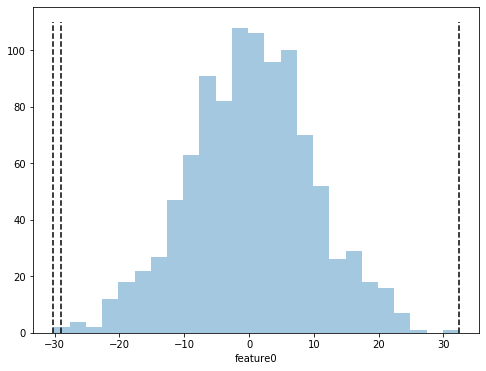

In [13]:
plt.figure(figsize=(8,6))
sns.distplot(dummydf['feature0'], kde=False);
plt.vlines(dummydf['feature0'][outlier_mask], ymin=0, ymax=110, linestyles='dashed');

### Compare Standard Deviation and IQR

In [16]:
# For comparison, make one array each using standard deviations of 2.0, 3.0 and 4.0.
std2 = dummydf.apply(out_std, nstd=2.0)
std3 = dummydf.apply(out_std, nstd=3.0)
std4 = dummydf.apply(out_std, nstd=4.0)

# For comparison, make one array each at varying values of k.
iqr1 = dummydf.apply(out_iqr, k=1.5)
iqr2 = dummydf.apply(out_iqr, k=2.0)
iqr3 = dummydf.apply(out_iqr, k=3.0)

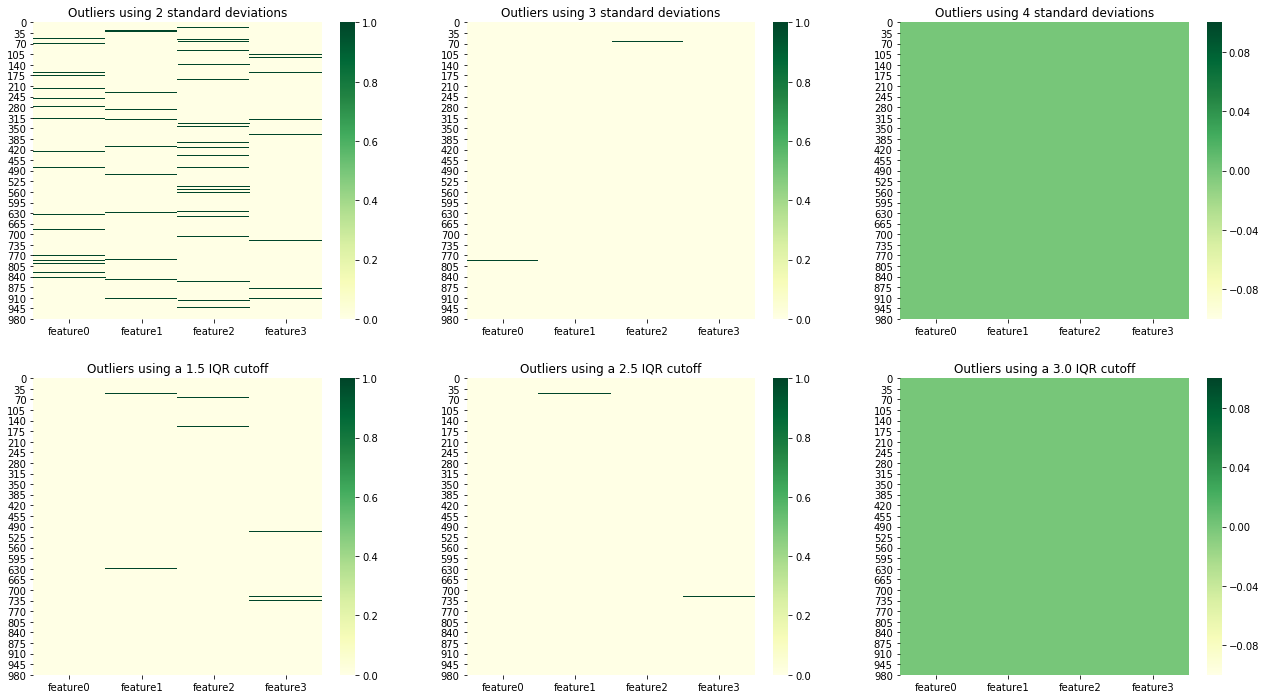

In [17]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(ncols=3, nrows=2, figsize=(22, 12));
ax1.set_title('Outliers using 2 standard deviations');
ax2.set_title('Outliers using 3 standard deviations');
ax3.set_title('Outliers using 4 standard deviations');
ax4.set_title('Outliers using a 1.5 IQR cutoff');
ax5.set_title('Outliers using a 2.5 IQR cutoff');
ax6.set_title('Outliers using a 3.0 IQR cutoff');

sns.heatmap(std2, cmap='YlGn', ax=ax1);
sns.heatmap(std3, cmap='YlGn', ax=ax2);
sns.heatmap(std4, cmap='YlGn', ax=ax3);
sns.heatmap(iqr1, cmap='YlGn', ax=ax4);
sns.heatmap(iqr2, cmap='YlGn', ax=ax5);
sns.heatmap(iqr3, cmap='YlGn', ax=ax6);

plt.savefig('outliers.png') # testing control of newsfeed figure: https://www.kaggle.com/questions-and-answers/57099#post330539
plt.show()

`feature0`에 대한 서로 다른 표준편차 Cut Off를 결정하고 이에 대한 시각화를 수행한다.

In [18]:
def plot_cutoff(dataframe, col, nstd=2.0, color='red'):
    """
    Version 8 update: more generic function.
    Function added in Version 6, more readable code than previous versions.
    From version 4 update: 
    This code block will plot lower and upper thresholds.
    I'm still thinking about how to best visualize this, suggestions welcome!
    """
    lower, upper = out_std(dataframe[col], nstd=nstd, return_thresholds=True)
    plt.axvspan(min(dataframe[col][dataframe[col] < lower], default=dataframe[col].min()), lower, alpha=0.2, color=color);
    plt.axvspan(upper, max(dataframe[col][dataframe[col] > upper], default=dataframe[col].max()), alpha=0.2, color=color);

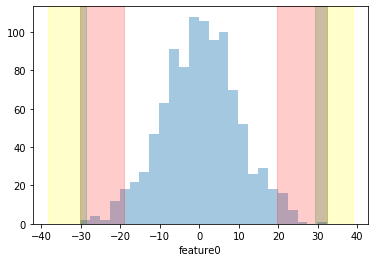

In [19]:
column = 'feature0'
sns.distplot(dummydf[column], kde=False)
plot_cutoff(dummydf, column, nstd=2.0, color='red');
plot_cutoff(dummydf, column, nstd=3.0, color='green');
plot_cutoff(dummydf, column, nstd=4.0, color='yellow');

# Nonparametric methods: Univariate

Melbourn Housing Dataset의 피쳐들은 분포가 정규 분포를 따르지 않기 때문에 Nonparametric 방법을 사용하여 Outlier을 탐색할 것이다.

In [21]:
df = pd.read_csv('../dataset/melbourne-housing-market/Melbourne_housing_FULL.csv')

In [22]:
# for this exercise, just fill missing values with the median value for a column.
# Using median ensures filled values will be whole numbers.
df.fillna(df.median(), inplace=True)

Outlier Detection은 데이터셋의 특정 열만을 가지고 수행할 것이다. 특정 열은 다음과 같다.

- Rooms
- Price
- Distance
- Bedroom2
- Bathroom
- Car
- Landsize
- Propertycount

In [23]:
cols = ['Rooms', 'Price', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'Propertycount']

다음은 특정 열들을 시각화한 결과이다. Parametric 방법을 이용할 때 데이터의 분포보다 매우 편향되어 있다는 것을 알 수 있다.

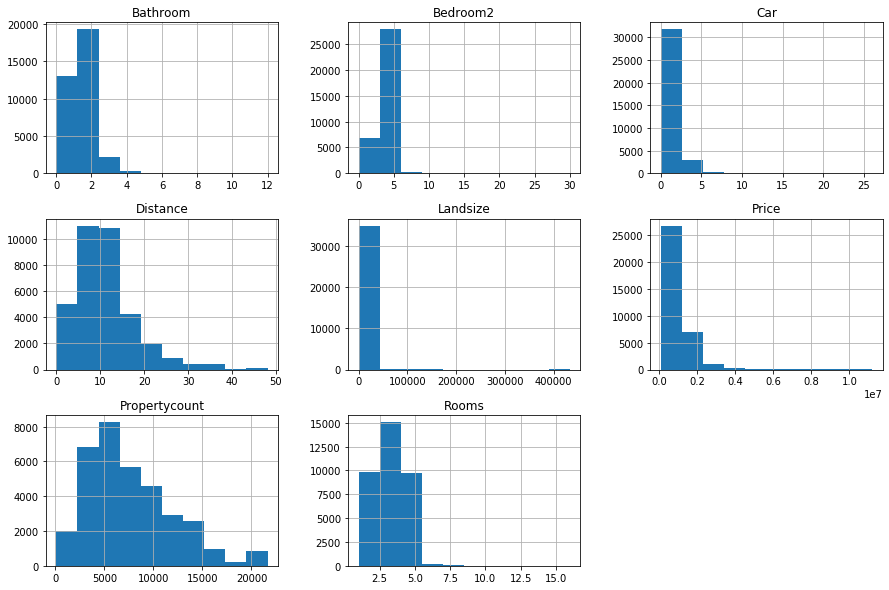

In [24]:
df[cols].hist(figsize=(15,10));


### Isolation Forest

[IsolationForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest)는 Scikit-Learn을 통해 구현할 수 있다. 각 데이터 포인트에 대한 `anomaly_score`를 반환한다.
아래의 코드가 다음 튜토리얼로 부터 수정되었다 [tutorial](https://dzone.com/articles/spotting-outliers-with-isolation-forest-using-skle).

In [38]:
isolation_forest = IsolationForest()
isolation_forest.fit(df['Bathroom'].values.reshape(-1,1))

IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [50]:
xx = np.linspace(df['Bathroom'].min(), df['Bathroom'].max(), len(df)).reshape(-1,1)
xx

array([[0.00000000e+00],
       [3.44273583e-04],
       [6.88547165e-04],
       ...,
       [1.19993115e+01],
       [1.19996557e+01],
       [1.20000000e+01]])

In [48]:
anomaly_score = isolation_forest.decision_function(xx)
anomaly_score

array([-0.07641222, -0.07641222, -0.07641222, ..., -0.34096483,
       -0.34096483, -0.34096483])

In [51]:
outlier = isolation_forest.predict(xx)
outlier

array([-1, -1, -1, ..., -1, -1, -1])

In [61]:
xx.T

array([[0.00000000e+00, 3.44273583e-04, 6.88547165e-04, ...,
        1.19993115e+01, 1.19996557e+01, 1.20000000e+01]])

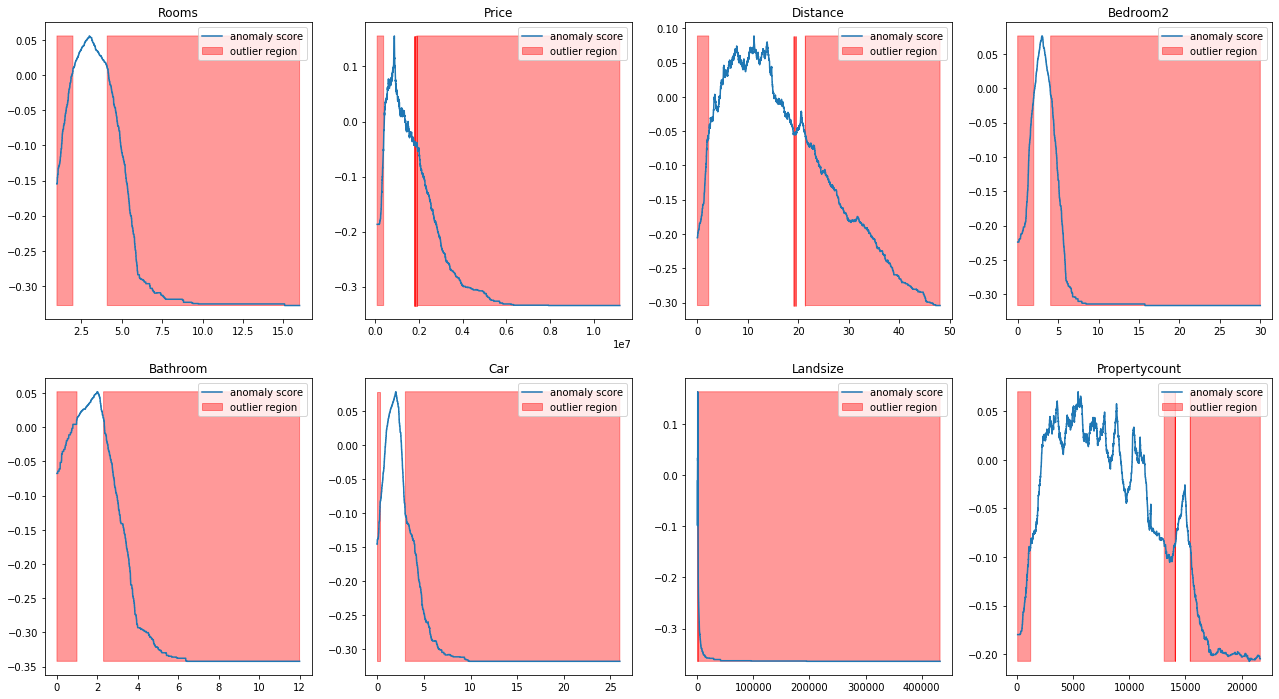

In [29]:
fig, axs = plt.subplots(2, 4, figsize=(22, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest()
    isolation_forest.fit(df[column].values.reshape(-1,1))

    xx = np.linspace(df[column].min(), df[column].max(), len(df)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)

Notice `PropertyCount` has a bimodal distribution. `OneClassSVM` might perform better in these cases.

# Parametric methods: Multivariate

I will show multivariate outlier detection using two scikit-learn methods: For normally distributed data (ex. `dummydf`), use [EllipticEnvelope](http://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope). 

### EllipticEnvelope  

For visualization purposes, use the first two features

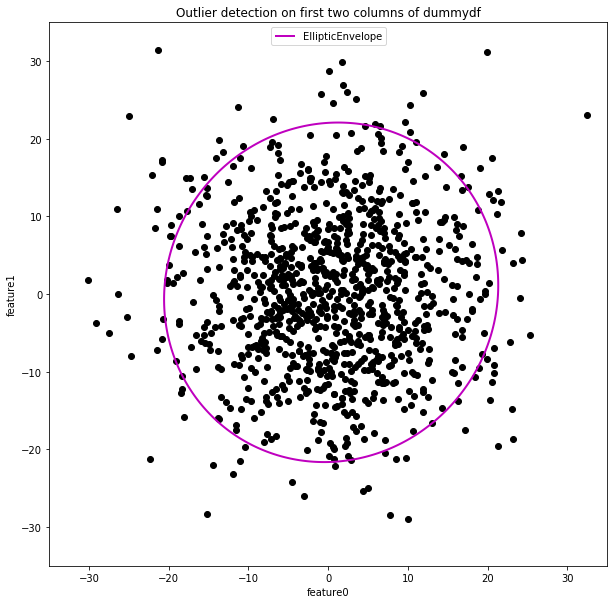

In [30]:
clf = EllipticEnvelope()

legend = {}
xx, yy = np.meshgrid(np.linspace(-35, 35, 500), np.linspace(-35, 35, 500))
plt.figure(1, figsize=(10,10))
clf.fit(dummydf.values[:,:2])
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
legend['EllipticEnvelope'] = plt.contour(
    xx, yy, Z, levels=[0], linewidths=2, colors=['m'])

legend_values_list = list(legend.values())
legend_keys_list = list(legend.keys())

plt.figure(1, figsize=(10,10))# two clusters
plt.title("Outlier detection on first two columns of dummydf")
plt.scatter(dummydf.values[:, 0], dummydf.values[:, 1], color='black')
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")

plt.xlim((xx.min(), xx.max()))
plt.ylim((yy.min(), yy.max()))
plt.legend(legend_values_list[0].collections, legend_keys_list,
           loc="upper center");
plt.ylabel("feature1");
plt.xlabel("feature0");

# Nonparametric methods: Multivariate

### DBSCAN

DBSCAN on Melbourne Housing Data  

For skewed distributions a quick and dirty method called [DBSCAN](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). [Here](http://scikit-learn.org/stable/auto_examples/applications/plot_outlier_detection_housing.html) is a good tutorial for other methods in scikit-learn.
This is a quick **nonparametric** method that can be used in **multivariate** analyses. Parameters that will significantly affect clusters and worth tuning are `eps` and `min_samples`.

In [ ]:
# scale data first
X = StandardScaler().fit_transform(df[cols].values)

db = DBSCAN(eps=3.0, min_samples=10).fit(X)
labels = db.labels_

In [ ]:
pd.Series(labels).value_counts()

Visualize the outlier *samples* in the context of the first two features,  `Rooms` and `Price`

In [ ]:
plt.figure(figsize=(10,10))

unique_labels = set(labels)
colors = ['blue', 'red']

for color,label in zip(colors, unique_labels):
    sample_mask = [True if l == label else False for l in labels]
    plt.plot(X[:,0][sample_mask], X[:, 1][sample_mask], 'o', color=color);
plt.xlabel('Standardized Number of Rooms');
plt.ylabel('Standardized Price');

### LocalOutlierFactor
I tried detecting outliers in the first two features again, but [LocalOutlierFactor](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor) may require fine-tuning.

In [ ]:
clf = LocalOutlierFactor(n_neighbors=50, contamination='auto')
y_pred = clf.fit_predict(X[:,:2])

In [ ]:
plt.figure(figsize=(10,10))
# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(-3, 14, num=200), np.linspace(-3, 18, num=200))
Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

in_mask = [True if l == 1 else False for l in y_pred]
out_mask = [True if l == -1 else False for l in y_pred]

plt.title("Local Outlier Factor (LOF)")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
# inliers
a = plt.scatter(X[in_mask, 0], X[in_mask, 1], c='white',
                edgecolor='k', s=20)
# outliers
b = plt.scatter(X[out_mask, 0], X[out_mask, 1], c='red',
                edgecolor='k', s=20)
plt.axis('tight')
plt.xlabel('Standardized Number of Rooms');
plt.ylabel('Standardized Price');
plt.show()

### Thank you for reading the kernel, suggestions for improvements, comments, and critiques welcome!